# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import date
import os

import sys
sys.path.insert(1, './../src/')

import time 

import pull_option_data 

from pathlib import Path

import bsm_pricer as bsm
from settings import config
import datetime
import level_1_filters as f1
import level_2_filters as f2
import level_3_filters as f3
import pull_option_data 
import pull_option_data as l1


import time 
import warnings
import wrds

from scipy.stats import norm, stats
from scipy.spatial.distance import cdist

In [2]:
from scipy import stats

In [3]:
from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis

In [4]:
import importlib

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
warnings.filterwarnings("ignore")

In [6]:
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
DATA_DIR = Path(config("DATA_DIR"))
DATA_DIR = DATA_DIR / "options"
WRDS_USERNAME = config("WRDS_USERNAME")

START_DATE_01 = date(1996, 1, 1)
END_DATE_01 = date(2012, 1, 31)

START_DATE_02 = date(2012, 2, 1)
END_DATE_02 = date(2019, 12, 31)


In [7]:
DATE_RANGE =f'{pd.Timestamp(START_DATE_01):%Y-%m}_{pd.Timestamp(END_DATE_02):%Y-%m}'

# Functions

In [8]:
# --- Black-Scholes elasticity ---
def bs_elasticity(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d1 - sigma * np.sqrt(T))
        delta = norm.cdf(d1)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d1 + sigma * np.sqrt(T)) - S * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    return (delta * S / price), price

# Gaussian kernel function
def kernel_weights(m_grid, ttm_grid, k_s, ttm, bw_m=0.0125, bw_t=10):
    m_grid = np.asarray(m_grid, dtype=float)
    ttm_grid = np.asarray(ttm_grid, dtype=float)
    x = (m_grid - k_s) / bw_m
    y = (ttm_grid - ttm) / bw_t
    dist_sq = x**2 + y**2
    weights = np.exp(-0.5 * dist_sq)
    return weights / weights.sum() if weights.sum() > 0 else np.zeros_like(weights)

# --- Construct a single day portfolio ---
def construct_portfolio(data, k_s_target, ttm_target, option_type='call', r=0.01):
    subset = data[(data['option_type'] == option_type)]
    weights = kernel_weights(subset['moneyness'], subset['ttm'], k_s_target, ttm_target)
    subset = subset.assign(weight=weights)
    subset = subset[subset['weight'] > 0.01]
    subset['weight'] /= subset['weight'].sum()

    # Leverage-adjusted returns
    elast, price = bs_elasticity(
        S=subset['underlying'], K=subset['strike'], T=subset['ttm']/365,
        r=r, sigma=subset['iv'], option_type=option_type
    )
    subset['leverage_return'] = subset['daily_return'] / elast

    return (subset['leverage_return'] * subset['weight']).sum()

# --- Main Loop (simplified) ---
def build_portfolios(option_data, m_grid, ttm_grid, option_types=['call', 'put']):
    portfolios = []
    for opt_type in option_types:
        for k_s in m_grid:
            for ttm in ttm_grid:
                ret = construct_portfolio(option_data, k_s, ttm, option_type=opt_type)
                portfolios.append({
                    'type': opt_type,
                    'moneyness': k_s,
                    'ttm': ttm,
                    'return': ret
                })
    return pd.DataFrame(portfolios)

def calc_kernel_weights(spx_mod):
    """ Calculate kernel weights for each option in the SPX dataset based on moneyness and maturity targets.
    This function iterates through predefined moneyness and maturity targets, applies kernel weights to candidate options."""
    
    # Define moneyness and maturity targets from the paper
    moneyness_targets = [0.90, 0.925, 0.950, 0.975, 1.000, 1.025, 1.050, 1.075, 1.100]
    maturity_targets = [30, 60, 90]
    cp_flags = ['C', 'P']

    # Preprocess base DataFrame
    spx_mod['days_to_maturity_int'] = spx_mod['days_to_maturity'].dt.days
    spx_mod = spx_mod.reset_index()
    spx_mod['original_index'] = spx_mod.index

    weight_results = []

    # Iterate through each strategy target
    for cp_flag in cp_flags:
        for target_moneyness in moneyness_targets:
            for target_ttm in maturity_targets:
                # Filter candidate options
                candidate_options = spx_mod[
                    (spx_mod['cp_flag'] == cp_flag) &
                    (spx_mod['moneyness_id'] == target_moneyness) &
                    (spx_mod['maturity_id'] == target_ttm)
                ].copy()

                if candidate_options.empty:
                    continue

                candidate_options['kernel_weight'] = np.nan

                # Apply kernel weights per date
                for date, g in candidate_options.groupby('date'):
                    idx = g.index
                    weights = kernel_weights(
                        g['moneyness'].values,
                        g['days_to_maturity_int'].values,
                        k_s=target_moneyness,
                        ttm=target_ttm
                    )
                    candidate_options.loc[idx, 'kernel_weight'] = weights

                weight_results.append(candidate_options[['original_index', 'kernel_weight']])

    # Merge weights back into spx_mod
    if weight_results:
        all_weights = pd.concat(weight_results).set_index('original_index')
        spx_mod.set_index('original_index', inplace=True)
        spx_mod['kernel_weight'] = all_weights['kernel_weight']
        spx_mod.reset_index(inplace=True)
    else:
        print("No matching options found for any target.")

    spx_mod.drop(columns=['original_index'], inplace=True)
    return spx_mod

In [9]:
def calc_option_delta_elasticity(df):
    df = df.copy()

    T = df['days_to_maturity'].dt.days / 365.
    S = df['close']
    K = df['strike_price']
    r = df['tb_m3'] / 100
    sigma = df['IV']
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    df = df.assign(
        option_delta = np.where(df['cp_flag'] == 'C', norm.cdf(d1), norm.cdf(d1) - 1),
        option_elasticity = lambda x: x['option_delta'] * x['close'] / x['mid_price']
    )
    
    return df


In [10]:
def read_option_data(filename):    
    # Example string interval: '(0.9, 0.95]'
    # Remove whitespace and parse the string into tuples
    def parse_interval_string(s):
        # Handle missing or malformed entries gracefully
        if pd.isnull(s) or not isinstance(s, str):
            return pd.NA  # or np.nan
        s = s.strip().replace('(', '').replace(']', '')
        try:
            left, right = map(float, s.split(','))
            return pd.Interval(left, right, closed='right')
        except ValueError:
            return pd.NA
    
    df = pd.read_parquet(filename)
    
    # restore the 'moneyness_bin' column as intervals
    df['moneyness_bin'] = df['moneyness_bin'].apply(parse_interval_string)
    
    return df

In [11]:
def compute_cjs_return_leverage_investment(spx_mod):
    df = spx_mod.copy()
    df = df.sort_values(['ftfsa_id', 'date'])

    # Lag price
    df['mid_price_lag'] = df.groupby('ftfsa_id')['mid_price'].shift(1)

    # Return and daily risk-free rate
    df['option_return'] = (df['mid_price'] - df['mid_price_lag']) / df['mid_price_lag']
    df['daily_rf'] = df['tb_m3'] / 100 / 252

    # Weighted dollar investment and return contribution
    df['inv_weight'] = df['kernel_weight'] / df['option_elasticity']
    df['inv_return'] = df['inv_weight'] * df['option_return']

    # Group and aggregate
    grouped = df.groupby(['date', 'ftfsa_id'])

    port = grouped.agg(
        total_inv_weight=('inv_weight', 'sum'),
        total_inv_return=('inv_return', 'sum'),
        daily_rf=('daily_rf', 'first'),
        cp_flag=('cp_flag', 'first')
    ).reset_index()

    # Apply CJS logic
    def adjusted_return(row):
        if row['cp_flag'] == 'C':
            return row['total_inv_return'] + (1 - row['total_inv_weight']) * row['daily_rf']
        elif row['cp_flag'] == 'P':
            return -row['total_inv_return'] + (1 + row['total_inv_weight']) * row['daily_rf']
        else:
            return np.nan

    port['portfolio_return'] = port.apply(adjusted_return, axis=1)

    return port


In [12]:
# Function to compute normality metrics
def normality_summary(df):
    summary = []
    for col in df.columns:
        series = df[col].dropna()
        shapiro_p = shapiro(series)[1]
        jb_stat, jb_p = jarque_bera(series)
        normaltest_p = normaltest(series)[1]
        skew_val = skew(series)
        kurt_val = kurtosis(series, fisher=False)
        summary.append({
            "Series": col,
            "Shapiro_p": shapiro_p,
            "JarqueBera_p": jb_p,
            "Normaltest_p": normaltest_p,
            "Skewness": skew_val,
            "Kurtosis": kurt_val
        })
    return pd.DataFrame(summary)

# Execution

In [13]:
# read filtered data
source_file = Path(DATA_DIR / f'spx_filtered_final_{DATE_RANGE}.parquet')
spx_filtered = read_option_data(filename=source_file)
spx_filtered = spx_filtered.reset_index()

# create the moneyness ID from the moneyness_bin column, using the right edge of the interval
spx_filtered['moneyness_id'] = spx_filtered['moneyness_bin'].apply(lambda x: x.right if pd.notnull(x) else np.nan)
# drop any rows where moneyness_id is NaN
spx_filtered = spx_filtered.dropna(subset=['moneyness_id'])

spx_filtered

,date,exdate,moneyness,secid,open,close,cp_flag,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,days_to_maturity,pc_parity_int_rate,intrinsic,log_iv,fitted_iv,rel_distance_iv,moneyness_bin,stdev_iv_moneyness_bin,is_outlier_iv,moneyness_id
0,1996-01-04,1996-01-20,0.987534,108105.0,621.32,617.70,C,0.082711,5.04,444.0,5905.0,10.0000,10.375,610.0,100.0,10.18750,16 days,0.015898,7.70,-2.492403,-2.377298,4.841838,"(0.975, 1.0]",3.516840,False,1.000
1,1996-01-04,1996-01-20,1.019913,108105.0,621.32,617.70,C,0.097356,5.04,4022.0,5969.0,1.1875,1.375,630.0,100.0,1.28125,16 days,0.015898,0.00,-2.329381,-2.285771,1.907866,"(1.0, 1.025]",5.219336,False,1.025
2,1996-01-04,1996-01-20,1.028007,108105.0,621.32,617.70,C,0.101756,5.04,1627.0,6224.0,0.6250,0.750,635.0,100.0,0.68750,16 days,0.015898,0.00,-2.285177,-2.264082,0.931727,"(1.025, 1.05]",4.396845,False,1.050
3,1996-01-04,1996-01-20,1.036102,108105.0,621.32,617.70,C,0.100588,5.04,0.0,6593.0,0.1875,0.375,640.0,100.0,0.28125,16 days,0.015898,0.00,-2.296722,-2.242870,2.401027,"(1.025, 1.05]",4.396845,False,1.050
4,1996-01-04,1996-02-17,0.963251,108105.0,621.32,617.70,C,0.071852,5.04,3.0,34.0,25.2500,26.250,595.0,100.0,25.75000,44 days,0.014622,22.70,-2.633147,-2.563785,2.705450,"(0.95, 0.975]",2.301503,False,0.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195881,2019-12-31,2020-06-19,1.044639,108105.0,3215.18,3230.78,P,0.117063,1.52,0.0,395.0,192.2000,193.000,3375.0,100.0,192.60000,171 days,0.014769,144.22,-2.145043,-2.132215,0.601630,"(1.025, 1.05]",4.396845,False,1.050
3195882,2019-12-31,2020-06-19,1.052377,108105.0,3215.18,3230.78,P,0.113900,1.52,0.0,163.0,208.2000,209.100,3400.0,100.0,208.65000,171 days,0.014769,169.22,-2.172434,-2.165558,0.317525,"(1.05, 1.075]",5.236635,False,1.075
3195883,2019-12-31,2020-06-19,1.060116,108105.0,3215.18,3230.78,P,0.110925,1.52,20.0,310.0,222.8000,228.900,3425.0,100.0,225.85000,171 days,0.014769,194.22,-2.198901,-2.199596,-0.031616,"(1.05, 1.075]",5.236635,False,1.075
3195884,2019-12-31,2020-06-19,1.067854,108105.0,3215.18,3230.78,P,0.108540,1.52,0.0,12.0,241.2000,247.600,3450.0,100.0,244.40000,171 days,0.014769,219.22,-2.220637,-2.234330,-0.612848,"(1.05, 1.075]",5.236635,False,1.075


## Construction of Monthly Leverage-Adjusted Portfolio Returns in CJS

### Process
The construction of the 27 call and 27 put portfolios in CJS is a multi-step process, with the objective of developing portfolio returns series that are stationary and only moderately skewed. Note that the discrete bucketing of moneyness and days to maturity lead to multiple candidate options for each portfolio on each trading day. These options  are given weights according to a **bivariate Gaussian weighting kernel** in moneyness and maturity (bandwidths: *0.0125 in moneyness* and *10 days to maturity*).

Each portfolio's daily returns are initially calculated as simple arithmetic return, assuming the option is bought and sold at its bid-ask midpoint at each rebalancing. The one-day arithmetic return is then converted to a **leverage-adjusted return**. This procedure is achieved by calculating the one-day return of a hypothetical portfolio with $\omega_{BSM}^{-1}$ dollars invested in the option, and $(1 - \omega^{-1})$ dollars invested in the risk-free rate, where $\omega_{BSM}$ is the BSM elasticity based on the implied volatility of the option. 

\begin{align}
\omega_{\text{BSM, Call}} &= \frac{\partial C_{\text{BSM}}}{\partial S} \cdot \frac{S}{C_{\text{BSM}}} > 1 \\
\omega_{\text{BSM, Put}}  &= \frac{\partial P_{\text{BSM}}}{\partial S} \cdot \frac{S}{P_{\text{BSM}}} < -1
\end{align}

Each **leverage-adjusted call portfolio** comprises of a long position in a fraction of a call, and some investment in the risk-free rate. 

Each **leverage-adjusted put portfolio** comprises of a short position in a fraction of a put, and >100% investment in the risk-free rate. 




<font color="blue">*For clarity, we present below the mathematics behind CJS' descriptions of the portfolio construction process. The following applies for a single trading day $t$, for a set of candidate call or put options. Portfolios in CJS are identified by 3 characteristics: option type (call or put), moneyness (9 discrete targets), and time to maturity (3 discrete targets). On any given day, it is rare to find options that exactly match the moneyness and maturity targets. Instead, there may be multiple options that are "close to" the target moneyness / maturity (each a **"candidate option"**). Furthermore, each candidate option has its own price and price sensitivity to changes in the underlying SPX index level. In order to arrive at a "price" for an option portfolio, CJS applies a **Gaussian weighting kernel** in moneyness and maturity, as described below. This kernel-weighted price across the candidate options on a given day is used as the price of the **option component** of the portfolio (the other component being the risk-free rate). This portfolio is leverage-adjusted using the BSM elasticity, in order to standardize the sensitivity of OTM and ITM portfolios to changes in the underlying.*</font>

#### 1. Gaussian Kernel Weighting

Let:

* $m_{i}$ = moneyness of option $i$
* $\tau_{i}$ = days to maturity of option $i$
* $k_{s}$ = target moneyness
* $\tau$ = target maturity
* $h_{m}$, $h_{\tau}$ = bandwidths for moneyness and maturity
* $d_{i}^2 = \left( \frac{m_{i} - k_{s}}{h_{m}} \right)^2 + \left( \frac{\tau_{i} - \tau}{h_{\tau}} \right)^2$

Then the unnormalized Gaussian weight for option $i$ is:

$$
w_{i}^* = \exp\left( -\frac{1}{2} d_{i}^2 \right)
$$

The normalized kernel weight:

$$
w_{i} = \frac{w_{i}^*}{\sum_j w_j^*}
$$

---

#### 2. Option Elasticity

Let:

* $S_{t}$ = underlying index level at time $t$
* $P_{i}$ = price of option $i$
* $\Delta_{i}$ = option delta

Then:

$$
\varepsilon_{i} = \frac{S_t \cdot \Delta_{i}}{P_{i}}
$$

---

#### 3. Arithmetic Return of Option $i$

Let:

* $P_{i,t-1}$ = price of option $i$ at time $t-1$
* $P_{i,t}$ = price of option $i$ at time $t$

Then:

$$
r_{i} = \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}}
$$

---

#### 4. Leverage-Adjusted Portfolio Construction

Let:

* $r_{f}$ = risk-free rate on day $t$

The leverage-adjusted return of the call portfolio is:

$$
R_t^{call} = \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \cdot r_{i} + \left(1 - \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \right) \cdot r_f
$$

The leverage-adjusted return of the put portfolio is:

$$
R_t^{put} = -\sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \cdot r_{i} + \left(1 + \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \right) \cdot r_f
$$



Below we implement this process. 
### Implementation
#### 1. Build the FTSFA ID for each portfolio

In [14]:
# identify the maturity ID based on the closest maturity to 30, 60, or 90 days
maturity_id = pd.concat((abs(spx_filtered['days_to_maturity'].dt.days - 30), abs(spx_filtered['days_to_maturity'].dt.days - 60), abs(spx_filtered['days_to_maturity'].dt.days - 90)), axis=1)
maturity_id.columns = [30, 60, 90]
spx_filtered['maturity_id'] = maturity_id.idxmin(axis=1)
spx_filtered['ftfsa_id'] = spx_filtered['cp_flag'] + '_' + (spx_filtered['moneyness_id']*1000).apply(lambda x: str(int(x)) if pd.notnull(x) and x == int(x) else str(x)) \
    + '_' + spx_filtered['maturity_id'].astype(str)

# set index to ftfsa_id and date
spx_filtered.set_index(['ftfsa_id', 'date'], inplace=True)
spx_filtered

exdate  moneyness     secid     open    close  \
ftfsa_id  date                                                           
C_1000_30 1996-01-04 1996-01-20   0.987534  108105.0   621.32   617.70   
C_1025_30 1996-01-04 1996-01-20   1.019913  108105.0   621.32   617.70   
C_1050_30 1996-01-04 1996-01-20   1.028007  108105.0   621.32   617.70   
          1996-01-04 1996-01-20   1.036102  108105.0   621.32   617.70   
C_975_30  1996-01-04 1996-02-17   0.963251  108105.0   621.32   617.70   
...                         ...        ...       ...      ...      ...   
P_1050_90 2019-12-31 2020-06-19   1.044639  108105.0  3215.18  3230.78   
P_1075_90 2019-12-31 2020-06-19   1.052377  108105.0  3215.18  3230.78   
          2019-12-31 2020-06-19   1.060116  108105.0  3215.18  3230.78   
          2019-12-31 2020-06-19   1.067854  108105.0  3215.18  3230.78   
P_1100_90 2019-12-31 2020-06-19   1.075592  108105.0  3215.18  3230.78   

                     cp_flag        IV  tb_m3  volume  open_interest  \
ftfsa_id  date                                                         
C_1000_30 1996-01-04       C  0.082711   5.04   444.0         5905.0   
C_1025_30 1996-01-04       C  0.097356   5.04  4022.0         5969.0   
C_1050_30 1996-01-04       C  0.101756   5.04  1627.0         6224.0   
          1996-01-04       C  0.100588   5.04     0.0         6593.0   
C_975_30  1996-01-04       C  0.071852   5.04     3.0           34.0   
...                      ...       ...    ...     ...            ...   
P_1050_90 2019-12-31       P  0.117063   1.52     0.0          395.0   
P_1075_90 2019-12-31       P  0.113900   1.52     0.0          163.0   
          2019-12-31       P  0.110925   1.52    20.0          310.0   
          2019-12-31       P  0.108540   1.52     0.0           12.0   
P_1100_90 2019-12-31       P  0.106814   1.52     0.0            0.0   

                      best_bid  best_offer  strike_price  contract_size  \
ftfsa_id  date                                                            
C_1000_30 1996-01-04   10.0000      10.375         610.0          100.0   
C_1025_30 1996-01-04    1.1875       1.375         630.0          100.0   
C_1050_30 1996-01-04    0.6250       0.750         635.0          100.0   
          1996-01-04    0.1875       0.375         640.0          100.0   
C_975_30  1996-01-04   25.2500      26.250         595.0          100.0   
...                        ...         ...           ...            ...   
P_1050_90 2019-12-31  192.2000     193.000        3375.0          100.0   
P_1075_90 2019-12-31  208.2000     209.100        3400.0          100.0   
          2019-12-31  222.8000     228.900        3425.0          100.0   
          2019-12-31  241.2000     247.600        3450.0          100.0   
P_1100_90 2019-12-31  260.9000     267.500        3475.0          100.0   

                      mid_price days_to_maturity  pc_parity_int_rate  \
ftfsa_id  date                                                         
C_1000_30 1996-01-04   10.18750          16 days            0.015898   
C_1025_30 1996-01-04    1.28125          16 days            0.015898   
C_1050_30 1996-01-04    0.68750          16 days            0.015898   
          1996-01-04    0.28125          16 days            0.015898   
C_975_30  1996-01-04   25.75000          44 days            0.014622   
...                         ...              ...                 ...   
P_1050_90 2019-12-31  192.60000         171 days            0.014769   
P_1075_90 2019-12-31  208.65000         171 days            0.014769   
          2019-12-31  225.85000         171 days            0.014769   
          2019-12-31  244.40000         171 days            0.014769   
P_1100_90 2019-12-31  264.20000         171 days            0.014769   

                      intrinsic    log_iv  fitted_iv  rel_distance_iv  \
ftfsa_id  date                                                          
C_1000_30 1996-01-04       7.70 -2.492403  -2.377298         4.841

In [15]:
portfolio_ids = spx_filtered.index.get_level_values('ftfsa_id').unique()
portfolio_ids

Index(['C_1000_30', 'C_1025_30', 'C_1050_30', 'C_975_30', 'C_1075_30',
       'C_950_60', 'C_975_60', 'C_1000_60', 'C_1025_60', 'C_1050_60',
       'C_1075_60', 'C_1100_30', 'C_900_60', 'C_925_60', 'C_950_30',
       'C_1100_60', 'C_925_30', 'C_900_30', 'C_900_90', 'C_925_90', 'C_950_90',
       'C_975_90', 'C_1050_90', 'C_1000_90', 'C_1025_90', 'C_1075_90',
       'C_1100_90', 'P_1000_30', 'P_1025_30', 'P_1050_30', 'P_975_30',
       'P_1075_30', 'P_950_60', 'P_975_60', 'P_1000_60', 'P_1025_60',
       'P_1050_60', 'P_1075_60', 'P_1100_30', 'P_900_60', 'P_925_60',
       'P_950_30', 'P_1100_60', 'P_925_30', 'P_900_30', 'P_900_90', 'P_925_90',
       'P_950_90', 'P_975_90', 'P_1050_90', 'P_1000_90', 'P_1025_90',
       'P_1075_90', 'P_1100_90'],
      dtype='object', name='ftfsa_id')

In [16]:
spx_filtered['days_to_maturity'].describe()

count                       2676696
mean     56 days 07:55:28.214186444
std      36 days 18:30:26.100585916
min                 7 days 00:00:00
25%                29 days 00:00:00
50%                49 days 00:00:00
75%                74 days 00:00:00
max               180 days 00:00:00
Name: days_to_maturity, dtype: object

#### 2. Calculate option elasticity and daily kernel weighting for candidate options for each portfolio. 

In [17]:
spx_mod = spx_filtered.copy()

# calculate option delta and elasticity
spx_mod = calc_option_delta_elasticity(spx_mod)
# calculate daily kernel weights for candidate options
spx_mod = calc_kernel_weights(spx_mod)
spx_mod

,ftfsa_id,date,exdate,moneyness,secid,open,close,cp_flag,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,days_to_maturity,pc_parity_int_rate,intrinsic,log_iv,fitted_iv,rel_distance_iv,moneyness_bin,stdev_iv_moneyness_bin,is_outlier_iv,moneyness_id,maturity_id,option_delta,option_elasticity,days_to_maturity_int,kernel_weight
0,C_1000_30,1996-01-04,1996-01-20,0.987534,108105.0,621.32,617.70,C,0.082711,5.04,444.0,5905.0,10.0000,10.375,610.0,100.0,10.18750,16 days,0.015898,7.70,-2.492403,-2.377298,4.841838,"(0.975, 1.0]",3.516840,False,1.000,30,0.805272,48.826136,16,4.123556e-01
1,C_1025_30,1996-01-04,1996-01-20,1.019913,108105.0,621.32,617.70,C,0.097356,5.04,4022.0,5969.0,1.1875,1.375,630.0,100.0,1.28125,16 days,0.015898,0.00,-2.329381,-2.285771,1.907866,"(1.0, 1.025]",5.219336,False,1.025,30,0.198018,95.465702,16,1.000000e+00
2,C_1050_30,1996-01-04,1996-01-20,1.028007,108105.0,621.32,617.70,C,0.101756,5.04,1627.0,6224.0,0.6250,0.750,635.0,100.0,0.68750,16 days,0.015898,0.00,-2.285177,-2.264082,0.931727,"(1.025, 1.05]",4.396845,False,1.050,30,0.118568,106.529727,16,2.829909e-01
3,C_1050_30,1996-01-04,1996-01-20,1.036102,108105.0,621.32,617.70,C,0.100588,5.04,0.0,6593.0,0.1875,0.375,640.0,100.0,0.28125,16 days,0.015898,0.00,-2.296722,-2.242870,2.401027,"(1.025, 1.05]",4.396845,False,1.050,30,0.058374,128.204965,16,7.170091e-01
4,C_975_30,1996-01-04,1996-02-17,0.963251,108105.0,621.32,617.70,C,0.071852,5.04,3.0,34.0,25.2500,26.250,595.0,100.0,25.75000,44 days,0.014622,22.70,-2.633147,-2.563785,2.705450,"(0.95, 0.975]",2.301503,False,0.975,30,0.960529,23.041498,44,4.015525e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676691,P_1050_90,2019-12-31,2020-06-19,1.044639,108105.0,3215.18,3230.78,P,0.117063,1.52,0.0,395.0,192.2000,193.000,3375.0,100.0,192.60000,171 days,0.014769,144.22,-2.145043,-2.132215,0.601630,"(1.025, 1.05]",4.396845,False,1.050,90,-0.661333,-11.093570,171,5.365533e-16
2676692,P_1075_90,2019-12-31,2020-06-19,1.052377,108105.0,3215.18,3230.78,P,0.113900,1.52,0.0,163.0,208.2000,209.100,3400.0,100.0,208.65000,171 days,0.014769,169.22,-2.172434,-2.165558,0.317525,"(1.05, 1.075]",5.236635,False,1.075,90,-0.700041,-10.839582,171,1.775800e-16
2676693,P_1075_90,2019-12-31,2020-06-19,1.060116,108105.0,3215.18,3230.78,P,0.110925,1.52,20.0,310.0,222.8000,228.900,3425.0,100.0,225.85000,171 days,0.014769,194.22,-2.198901,-2.199596,-0.031616,"(1.05, 1.075]",5.236635,False,1.075,90,-0.737984,-10.556841,171,4.495126e-16
2676694,P_1075_90,2019-12-31,2020-06-19,1.067854,108105.0,3215.18,3230.78,P,0.108540,1.52,0.0,12.0,241.2000,247.600,3450.0,100.0,244.40000,171 days,0.014769,219.22,-2.220637,-2.234330,-0.612848,"(1.05, 1.075]",5.236635,False,1.075,90,-0.773579,-10.226122,171,7.756405e-16


In [18]:
print("Kernel weight check: All portfolios should sum to 1.0.")
spx_mod.groupby(['date', 'ftfsa_id'])['kernel_weight'].sum().round(15).value_counts()

Kernel weight check: All portfolios should sum to 1.0.


kernel_weight
1.0    156522
Name: count, dtype: int64

#### 3. Remove options from the portfolio with weights lower than 1%

In [19]:
spx_mod = spx_mod[spx_mod['kernel_weight']>=0.01].reset_index(drop=True)
spx_mod

,ftfsa_id,date,exdate,moneyness,secid,open,close,cp_flag,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,days_to_maturity,pc_parity_int_rate,intrinsic,log_iv,fitted_iv,rel_distance_iv,moneyness_bin,stdev_iv_moneyness_bin,is_outlier_iv,moneyness_id,maturity_id,option_delta,option_elasticity,days_to_maturity_int,kernel_weight
0,C_1000_30,1996-01-04,1996-01-20,0.987534,108105.0,621.32,617.70,C,0.082711,5.04,444.0,5905.0,10.0000,10.375,610.0,100.0,10.18750,16 days,0.015898,7.70,-2.492403,-2.377298,4.841838,"(0.975, 1.0]",3.516840,False,1.000,30,0.805272,48.826136,16,0.412356
1,C_1025_30,1996-01-04,1996-01-20,1.019913,108105.0,621.32,617.70,C,0.097356,5.04,4022.0,5969.0,1.1875,1.375,630.0,100.0,1.28125,16 days,0.015898,0.00,-2.329381,-2.285771,1.907866,"(1.0, 1.025]",5.219336,False,1.025,30,0.198018,95.465702,16,1.000000
2,C_1050_30,1996-01-04,1996-01-20,1.028007,108105.0,621.32,617.70,C,0.101756,5.04,1627.0,6224.0,0.6250,0.750,635.0,100.0,0.68750,16 days,0.015898,0.00,-2.285177,-2.264082,0.931727,"(1.025, 1.05]",4.396845,False,1.050,30,0.118568,106.529727,16,0.282991
3,C_1050_30,1996-01-04,1996-01-20,1.036102,108105.0,621.32,617.70,C,0.100588,5.04,0.0,6593.0,0.1875,0.375,640.0,100.0,0.28125,16 days,0.015898,0.00,-2.296722,-2.242870,2.401027,"(1.025, 1.05]",4.396845,False,1.050,30,0.058374,128.204965,16,0.717009
4,C_975_30,1996-01-04,1996-02-17,0.963251,108105.0,621.32,617.70,C,0.071852,5.04,3.0,34.0,25.2500,26.250,595.0,100.0,25.75000,44 days,0.014622,22.70,-2.633147,-2.563785,2.705450,"(0.95, 0.975]",2.301503,False,0.975,30,0.960529,23.041498,44,0.401552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926209,P_1100_90,2019-12-31,2020-03-31,1.077139,108105.0,3215.18,3230.78,P,0.102622,1.52,0.0,0.0,251.8000,258.300,3480.0,100.0,255.05000,91 days,0.015048,249.22,-2.276703,-2.342683,-2.816445,"(1.075, 1.1]",5.723928,False,1.100,90,-0.911590,-11.547335,91,0.066978
1926210,P_1100_90,2019-12-31,2020-03-31,1.080234,108105.0,3215.18,3230.78,P,0.099399,1.52,0.0,0.0,258.2000,269.200,3490.0,100.0,263.70000,91 days,0.015048,259.22,-2.308613,-2.356986,-2.052300,"(1.075, 1.1]",5.723928,False,1.100,90,-0.927007,-11.357435,91,0.102163
1926211,P_1100_90,2019-12-31,2020-03-31,1.083330,108105.0,3215.18,3230.78,P,0.102206,1.52,0.0,2.0,267.7000,279.600,3500.0,100.0,273.65000,91 days,0.015048,269.22,-2.280765,-2.371357,-3.820268,"(1.075, 1.1]",5.723928,False,1.100,90,-0.929031,-10.968371,91,0.146563
1926212,P_1100_90,2019-12-31,2020-03-31,1.091068,108105.0,3215.18,3230.78,P,0.103736,1.52,0.0,0.0,291.6000,303.600,3525.0,100.0,297.60000,91 days,0.015048,294.22,-2.265906,-2.407588,-5.884824,"(1.075, 1.1]",5.723928,False,1.100,90,-0.943358,-10.241205,91,0.276281


In [20]:
# check elasticity > 1 for call options and < -1 for put options
print("Elasticity > 1 for call options?")
spx_mod[spx_mod['cp_flag']=='C']['option_elasticity'].describe()['min'] > 1.0

Elasticity > 1 for call options?


True

In [21]:
print("Elasticity < -1 for put options?")
spx_mod[spx_mod['cp_flag']=='P']['option_elasticity'].describe()['max'] < -1.0

Elasticity < -1 for put options?


True

#### 4. Calculate the daily arithmetic return and the leverage-adjusted return of each portfolio. 

On each trading day, the return of a portfolio is calculated as the <u>weighted average return of the set of candidate options that comprise a single day's option portfolio</u>. The weighting used is the Gaussian kernel weight calculated earlier. Thus the daily return from period $t$ to $t+1$ represents the return from holding a set of candidate options, weighted using the kernel weights as of $t$, from period $t$ to $t+1$. 


In [22]:
portfolio_returns = compute_cjs_return_leverage_investment(spx_mod)

# Preview result
portfolio_returns.set_index(['date', 'ftfsa_id'], inplace=True)

portfolio_returns = portfolio_returns.pivot_table(index='date', columns='ftfsa_id', values='portfolio_return')
# daily_returns = pd.DataFrame(np.where(portfolio_returns > 1.0, np.nan, portfolio_returns), index=portfolio_returns.index, columns=portfolio_returns.columns)
daily_returns = portfolio_returns.copy()
daily_returns

ftfsa_id,C_1000_30,C_1000_60,C_1000_90,C_1025_30,C_1025_60,C_1025_90,C_1050_30,C_1050_60,C_1050_90,C_1075_30,C_1075_60,C_1075_90,C_1100_30,C_1100_60,C_1100_90,C_900_30,C_900_60,C_900_90,C_925_30,C_925_60,C_925_90,C_950_30,C_950_60,C_950_90,C_975_30,C_975_60,C_975_90,P_1000_30,P_1000_60,P_1000_90,P_1025_30,P_1025_60,P_1025_90,P_1050_30,P_1050_60,P_1050_90,P_1075_30,P_1075_60,P_1075_90,P_1100_30,P_1100_60,P_1100_90,P_900_30,P_900_60,P_900_90,P_925_30,P_925_60,P_925_90,P_950_30,P_950_60,P_950_90,P_975_30,P_975_60,P_975_90
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-04,0.002171,NaN,NaN,0.000198,NaN,NaN,-0.003106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003604,NaN,NaN,0.006069,NaN,NaN,0.000193,NaN,NaN,0.009051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003393,NaN,NaN
1996-01-05,NaN,NaN,NaN,-0.002985,NaN,NaN,0.004674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000760,NaN,NaN,-0.007415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-09,-0.004362,-0.005736,NaN,0.011077,0.000193,NaN,0.039018,0.000195,NaN,0.008154,0.000196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000186,NaN,-0.000977,-0.005790,NaN,0.007256,0.007409,NaN,0.009330,0.000188,NaN,0.009060,0.000186,NaN,0.008965,0.000183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000191,NaN,0.011241,0.007766,NaN
1996-01-10,-0.001291,NaN,NaN,NaN,NaN,NaN,-0.003064,NaN,NaN,-0.005087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002476,NaN,NaN,NaN,NaN,NaN,0.008751,NaN,NaN,-0.015005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-22,-0.002792,NaN,NaN,-0.004186,NaN,NaN,0.004054,NaN,NaN,0.016734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009674,NaN,NaN,0.008213,NaN,NaN,0.008817,NaN,NaN,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,NaN,NaN,NaN,-0.001959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001039,-0.001018,NaN,-0.000626,0.006539,NaN,NaN,0.006020,0.003000,NaN,NaN,NaN,NaN,NaN,-0.000775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000886,0.000877,NaN,0.000702,-0.003096,NaN,NaN,0.007690,-0.007144,NaN,NaN
2019-12-26,0.000177,-0.000588,-0.001565,0.049612,0.000451,-0.001096,0.001201,0.000729,NaN,0.001499,-0.000540,-0.001867,NaN,NaN,NaN,-0.000608,-0.000771,-0.001096,-0.000200,-0.000862,-0.001450,-0.000102,-0.000799,-0.001567,0.000011,-0.000786,-0.001644,0.000736,0.001082,0.001069,0.003282,0.001151,0.001065,0.001528,0.001665,NaN,0.001659,0.004004,-0.002207,NaN,NaN,NaN,0.000699,0.000805,0.000925,0.000619,0.000816,0.001072,0.000456,0.000826,0.000696,0.002388,0.000837,0.000776
2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003203,-0.001064,-0.001036,NaN,0.000144,-0.001147,NaN,NaN,-0.001185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002822,0.000971,0.001085,NaN,0.000463,0.002847,NaN,NaN,0.002921,NaN,NaN,NaN


#### 5. (to be implemented) Filling NaNs
CJS implement an multi-step process to deal with options with missing prices (detailed in section **1.3 Portfolio Formation** of the paper). We reserve the implementation this NaN-filling process for a future version of this dataset. For the current version, we compound the daily portfolio returns into monthly returns, which is the final form of the data utilized in the paper.  

#### 6. Compound Daily Portfolio Returns to Monthly (final 54 portfolios in CJS)

In [23]:
cjs_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
cjs_returns = cjs_returns.reset_index().melt(id_vars='date', var_name='ftfsa_id', value_name='return')
cjs_returns['ftfsa_id'] = 'cjs_'+cjs_returns['ftfsa_id']
cjs_returns = cjs_returns[['ftfsa_id', 'date', 'return']].set_index(['ftfsa_id', 'date'])
# save to data directory
cjs_returns.to_parquet(DATA_DIR / f'cjs_portfolio_returns_{DATE_RANGE}.parquet', index=True)
cjs_returns

return
ftfsa_id      date                
cjs_C_1000_30 1996-01-31 -0.006272
              1996-02-29  0.002888
              1996-03-31 -0.002462
              1996-04-30  0.036055
              1996-05-31  0.003906
...                            ...
cjs_P_975_90  2019-08-31  0.007421
              2019-09-30  0.000517
              2019-10-31  0.138853
              2019-11-30  0.009941
              2019-12-31  0.007702

[15552 rows x 1 columns]

## Construction of 18 Portfolio Return Series in He, Kelly, Manela (HKM 2017)

*HKM 2017* reduces the 54 portfolio return series constructed in CJS to 18 by taking an equal-weight average across the 3 maturities for the CJS portfolios with the same moneyness. Below we implement that procedure to obtain the final return series for the FTSFA. 

In [24]:
hkm_returns = cjs_returns.copy().reset_index()
hkm_returns = hkm_returns.assign(
    type=hkm_returns['ftfsa_id'].apply(lambda x: x.split('_')[1]),
    moneyness_id=hkm_returns['ftfsa_id'].apply(lambda x: x.split('_')[2]),
    maturity_id=hkm_returns['ftfsa_id'].apply(lambda x: x.split('_')[3])
)
hkm_returns.drop(columns=['ftfsa_id'], inplace=True)
hkm_returns.set_index(['date', 'type', 'moneyness_id', 'maturity_id'], inplace=True)
hkm_returns = hkm_returns.groupby(['date', 'type', 'moneyness_id']).mean()
hkm_returns['ftfsa_id'] = 'hkm_'+hkm_returns.index.get_level_values('type') + '_' + hkm_returns.index.get_level_values('moneyness_id')
hkm_returns = hkm_returns.reset_index().drop(columns=['type', 'moneyness_id']).set_index(['ftfsa_id', 'date']).sort_index()
# save to data directory
hkm_returns.to_parquet(DATA_DIR / f'hkm_portfolio_returns_{DATE_RANGE}.parquet', index=True)
hkm_returns


return
ftfsa_id   date                
hkm_C_1000 1996-01-31 -0.004002
           1996-02-29 -0.000919
           1996-03-31 -0.000821
           1996-04-30  0.012018
           1996-05-31  0.000912
...                         ...
hkm_P_975  2019-08-31  0.013859
           2019-09-30  0.006864
           2019-10-31  0.050960
           2019-11-30  0.010639
           2019-12-31  0.000444

[5184 rows x 1 columns]

---

## Data Discussion 

***Note:** Code below is for testing and discussion, not final publication.*

In [25]:
test_data = hkm_returns.copy()
# test_data = cjs_returns.copy()

test_data = test_data.reset_index().pivot_table(columns='ftfsa_id', index='date', values='return')

#### Tests for Normality of Returns

,Series,Shapiro_p,JarqueBera_p,Normaltest_p,Skewness,Kurtosis
0,hkm_C_1000,0.00,0.70,0.61,-0.06,3.21
1,hkm_C_1025,0.00,0.00,0.00,9.84,129.34
2,hkm_C_1050,0.00,0.00,0.00,4.75,36.59
3,hkm_C_1075,0.00,0.00,0.00,3.88,27.00
4,hkm_C_1100,0.00,0.00,0.00,4.44,30.64
5,hkm_C_900,0.00,0.00,0.00,-0.70,2.99
6,hkm_C_925,0.00,0.00,0.00,-0.58,2.34
7,hkm_C_950,0.00,0.00,0.00,-0.51,2.19
8,hkm_C_975,0.00,0.22,0.22,-0.24,2.87
9,hkm_P_1000,0.00,0.00,0.00,0.77,2.84


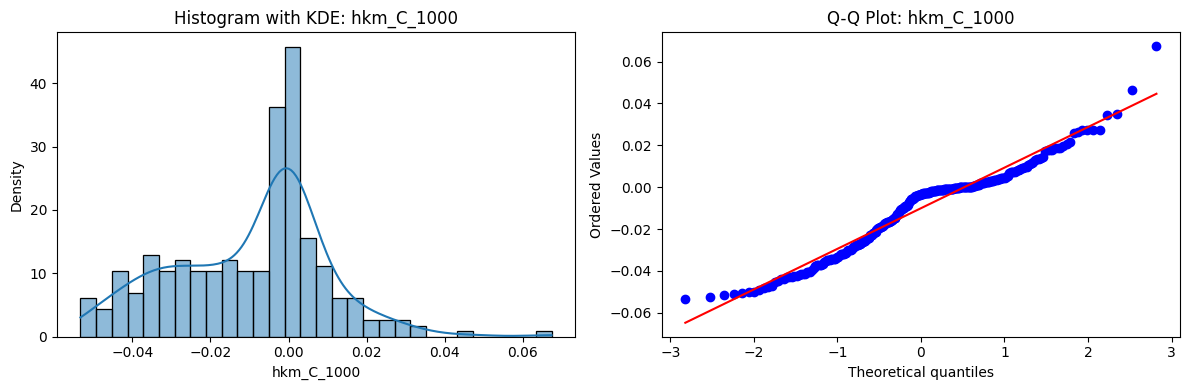

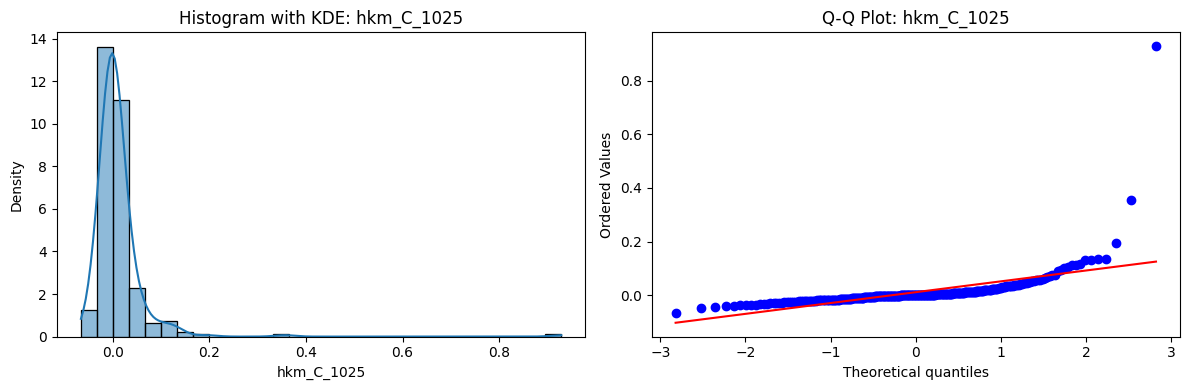

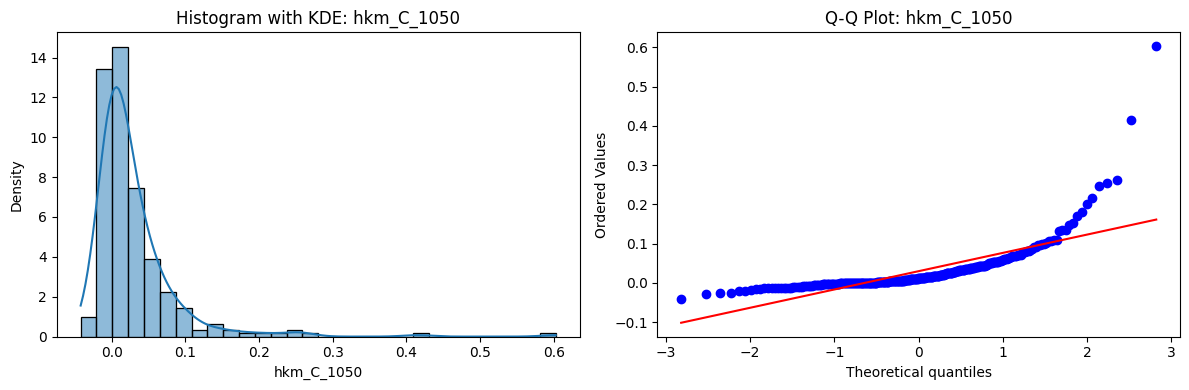

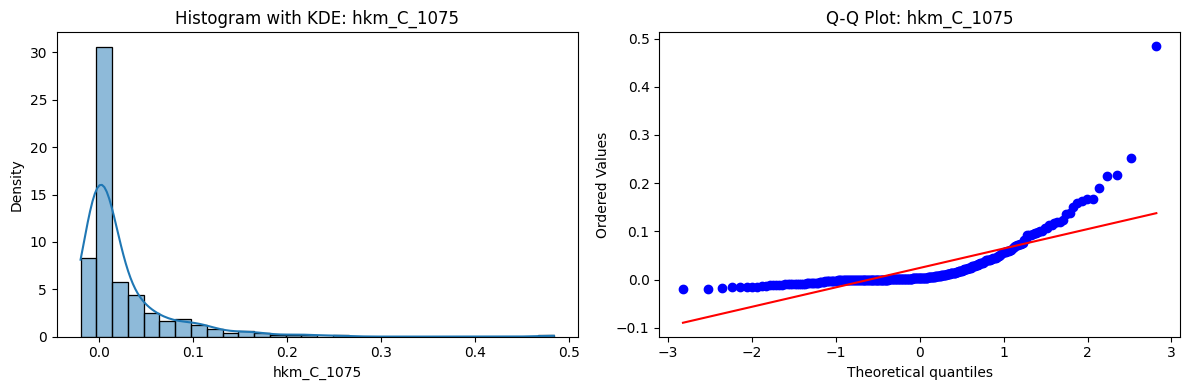

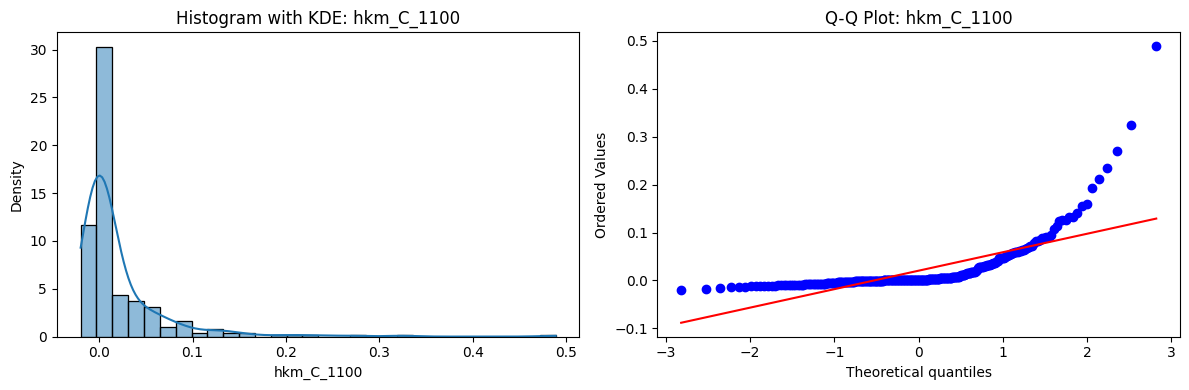

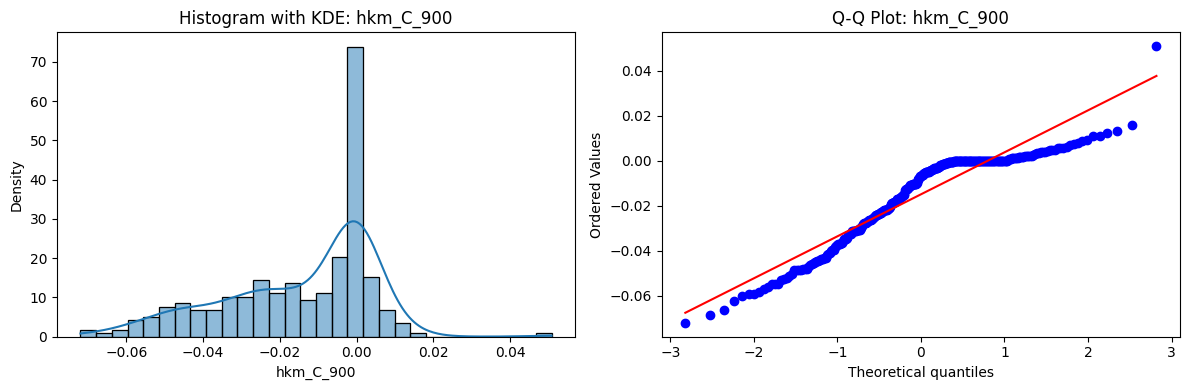

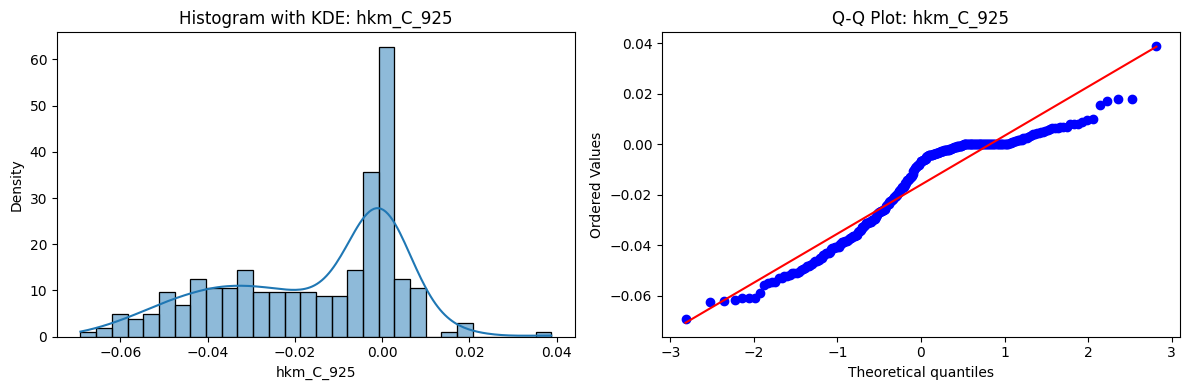

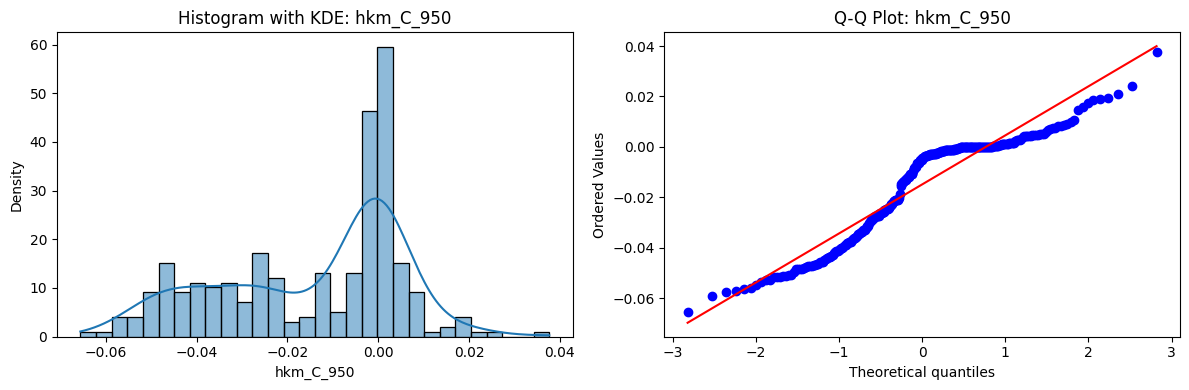

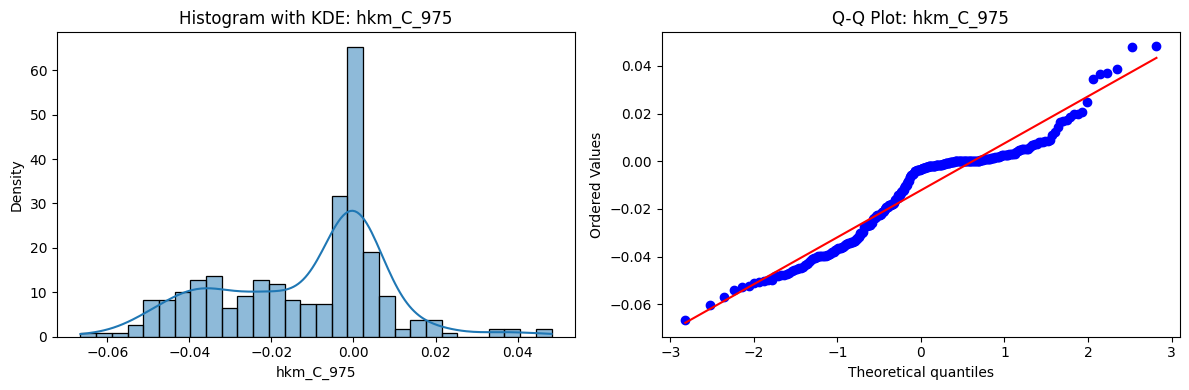

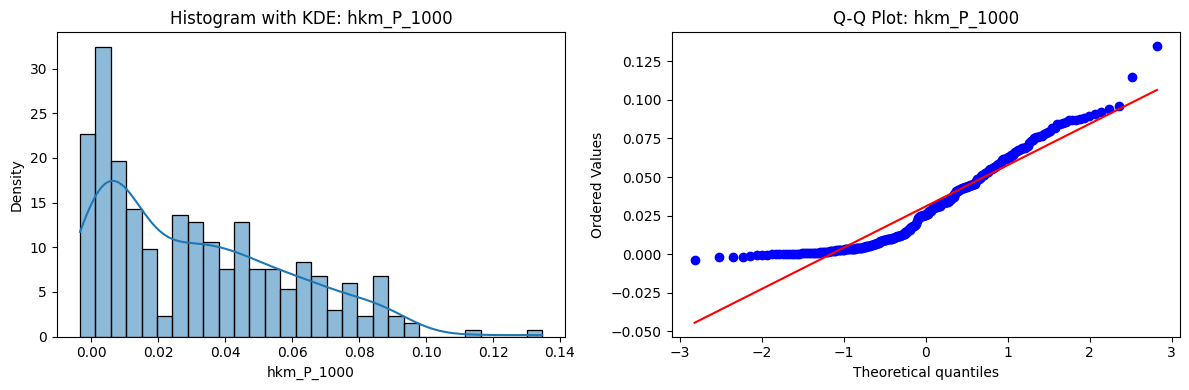

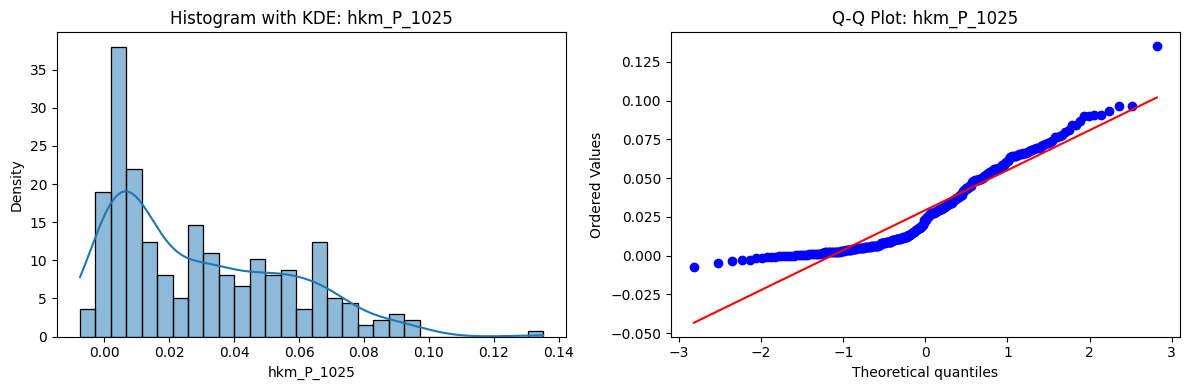

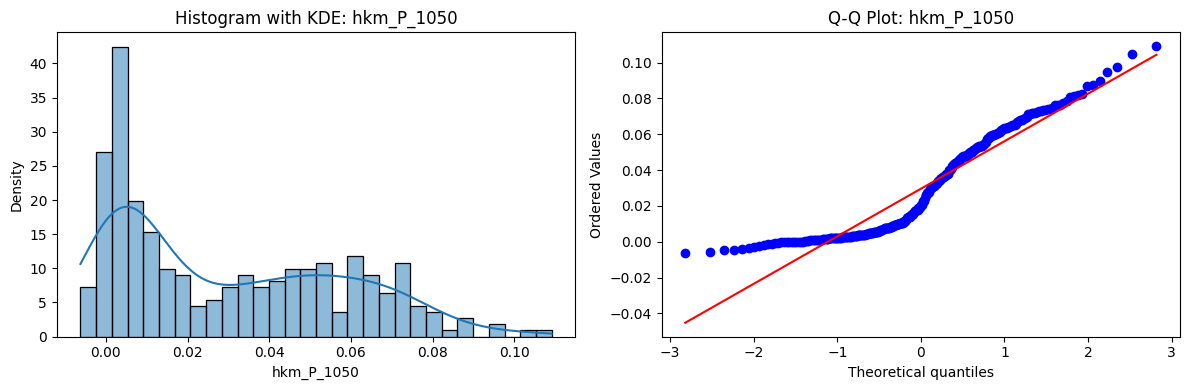

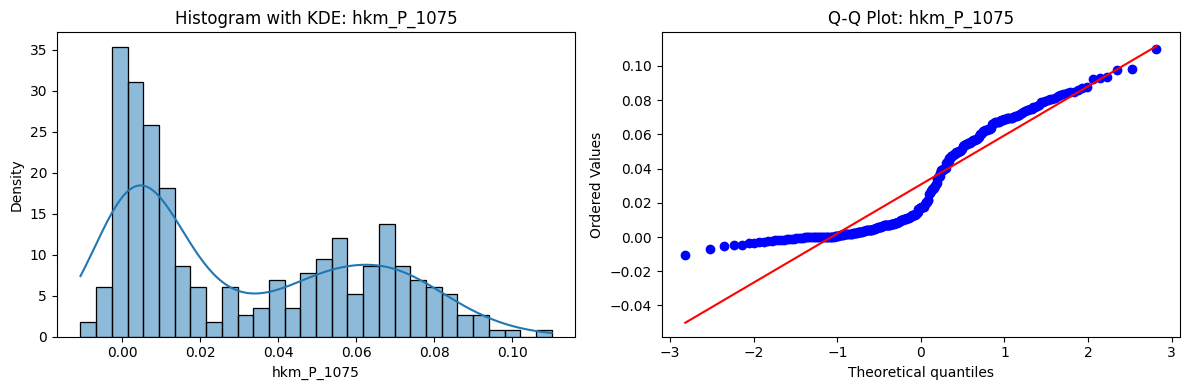

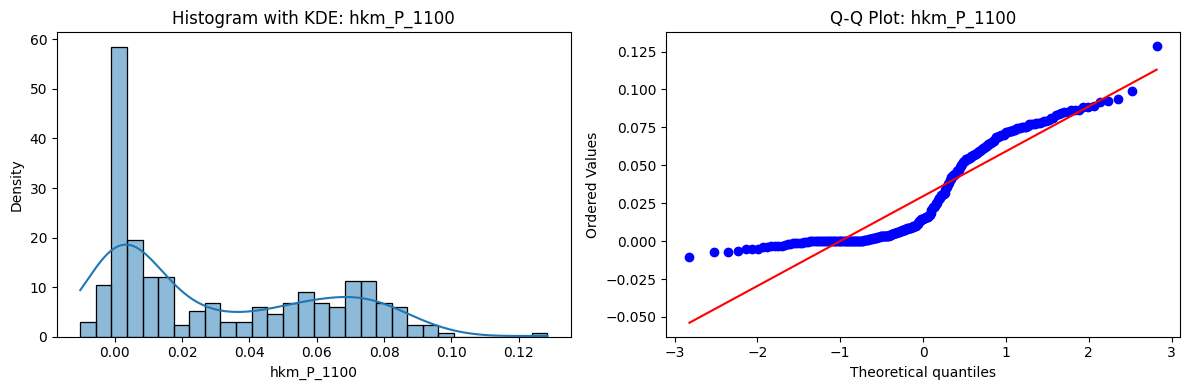

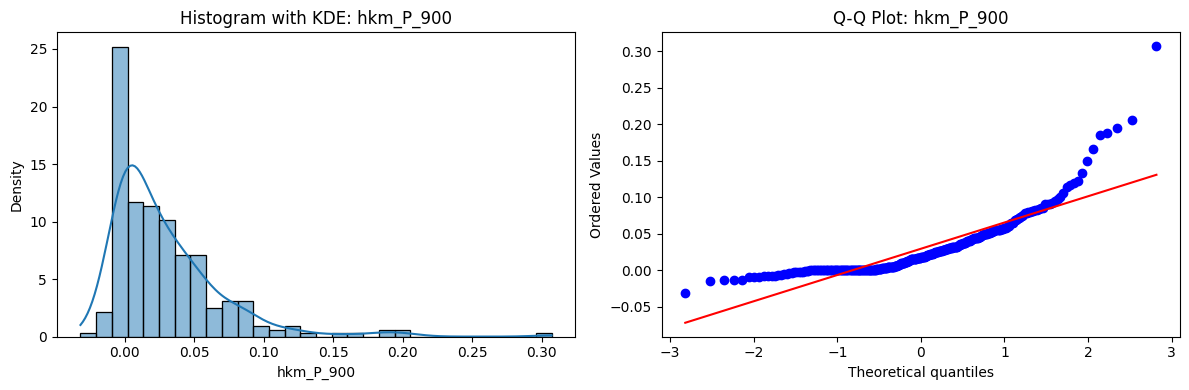

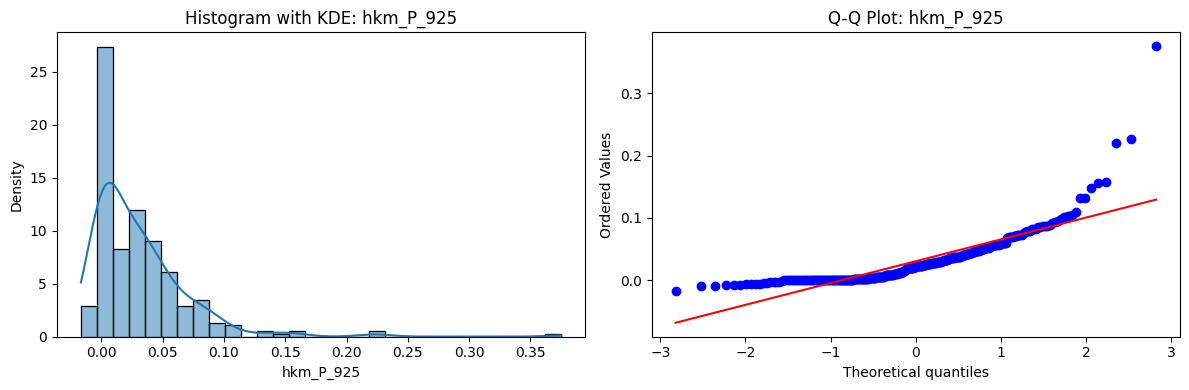

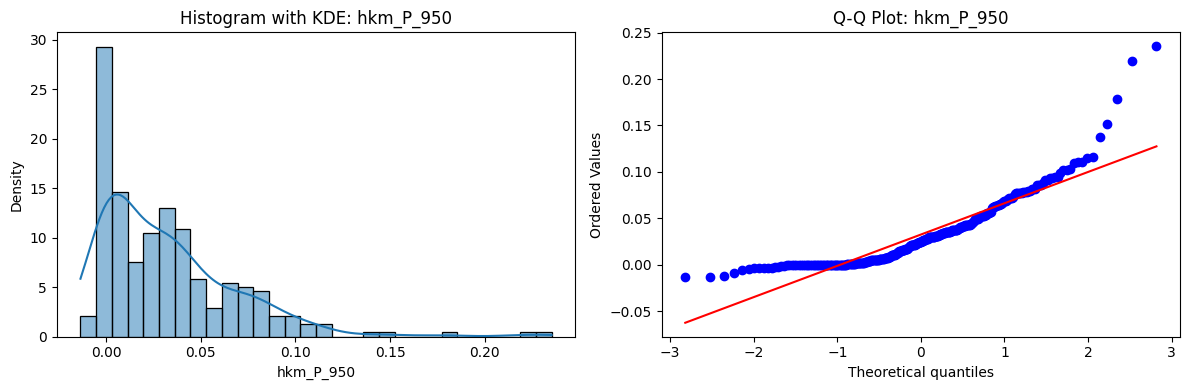

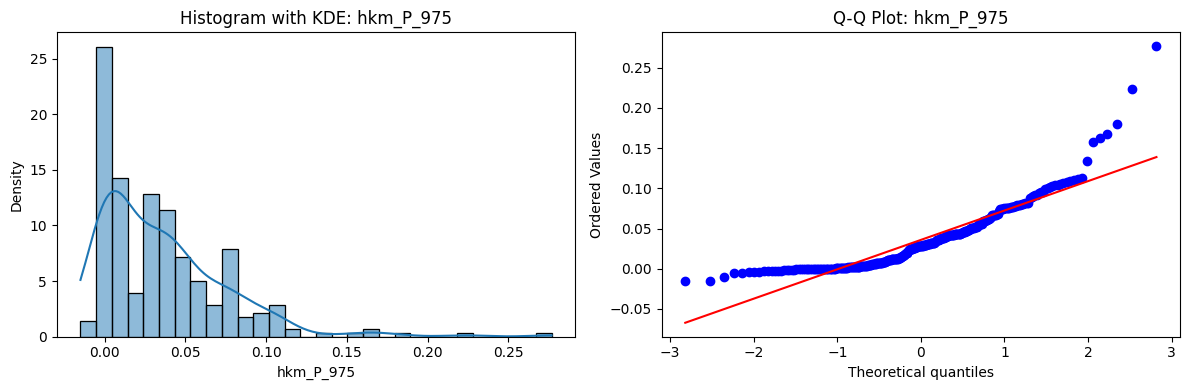

In [26]:
returns_df = test_data.copy()

# Apply to returns dataframe
summary_df = normality_summary(returns_df)
display(summary_df.style.format(na_rep='NaN', precision=2))

# Plot histogram and QQ plot for each series
for col in returns_df.columns:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(returns_df[col].dropna(), kde=True, stat="density", bins=30, ax=axs[0])
    axs[0].set_title(f"Histogram with KDE: {col}")
    
    stats.probplot(returns_df[col].dropna(), dist="norm", plot=axs[1])
    axs[1].set_title(f"Q-Q Plot: {col}")
    
    plt.tight_layout()
    plt.show()


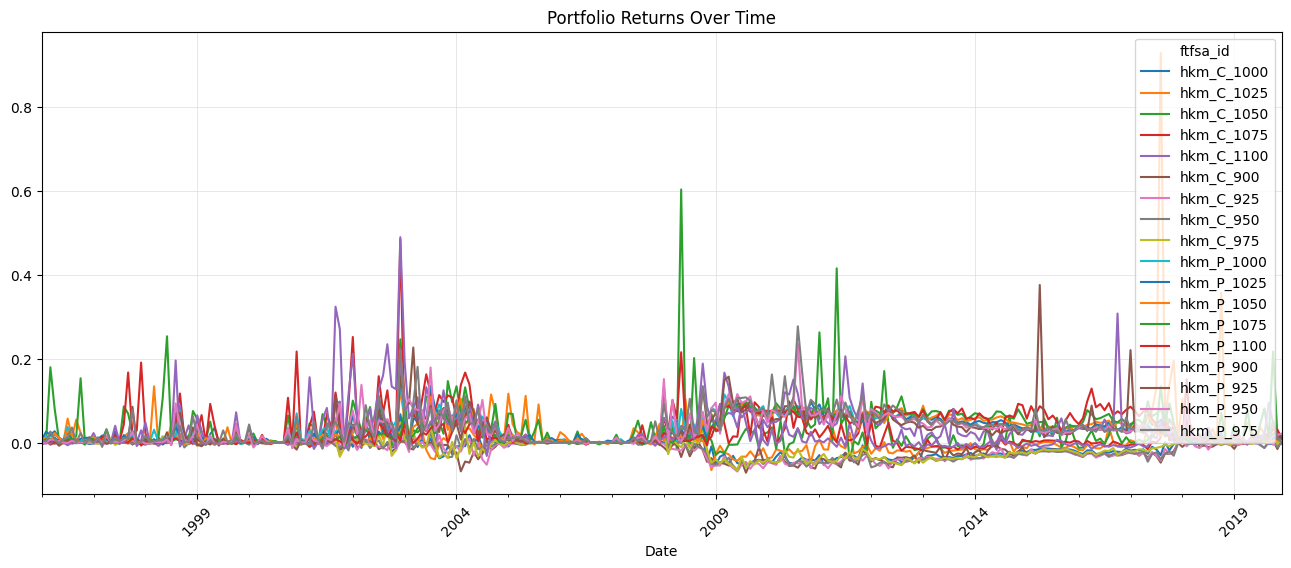

In [27]:
# plot groups of portfolios as line charts
portfolio_list = [] #['hkm_C_1000', 'hkm_P_1000'],['cjs_P_950_30', 'cjs_P_1025_60', 'cjs_C_1000_90']

chart_data = test_data[portfolio_list] if portfolio_list else test_data

chart_data.plot(figsize=(16, 6), title='Portfolio Returns Over Time')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().grid(True, which='major', color='#dddddd', linewidth=0.5)
plt.show()

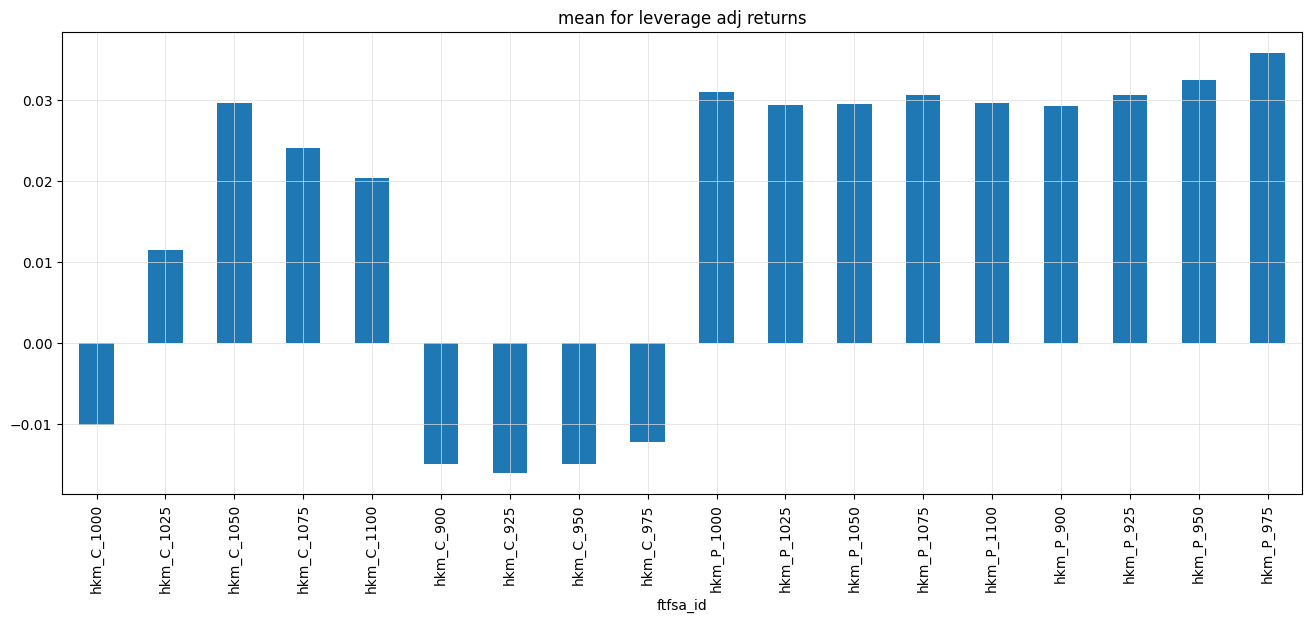

In [28]:
metric = 'mean'
chart_data.describe().T[metric].plot(kind='bar', figsize=(16, 6), title=f'{metric} for leverage adj returns')
plt.gca().grid(True, which='major', color='#dddddd', linewidth=0.5)

plt.show()

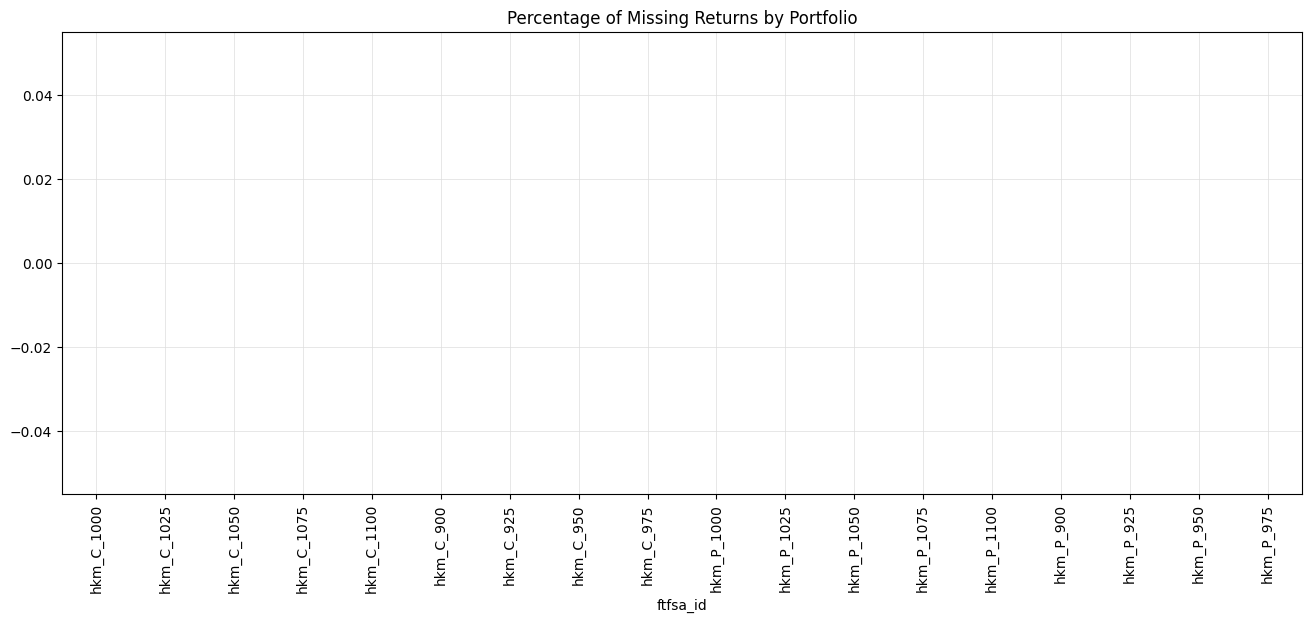

In [29]:
(test_data.isna().sum() / test_data.shape[0]).plot(kind='bar', color='lightblue', figsize=(16, 6), title='Percentage of Missing Returns by Portfolio')
plt.gca().grid(True, which='major', color='#dddddd', linewidth=0.5)
plt.show()

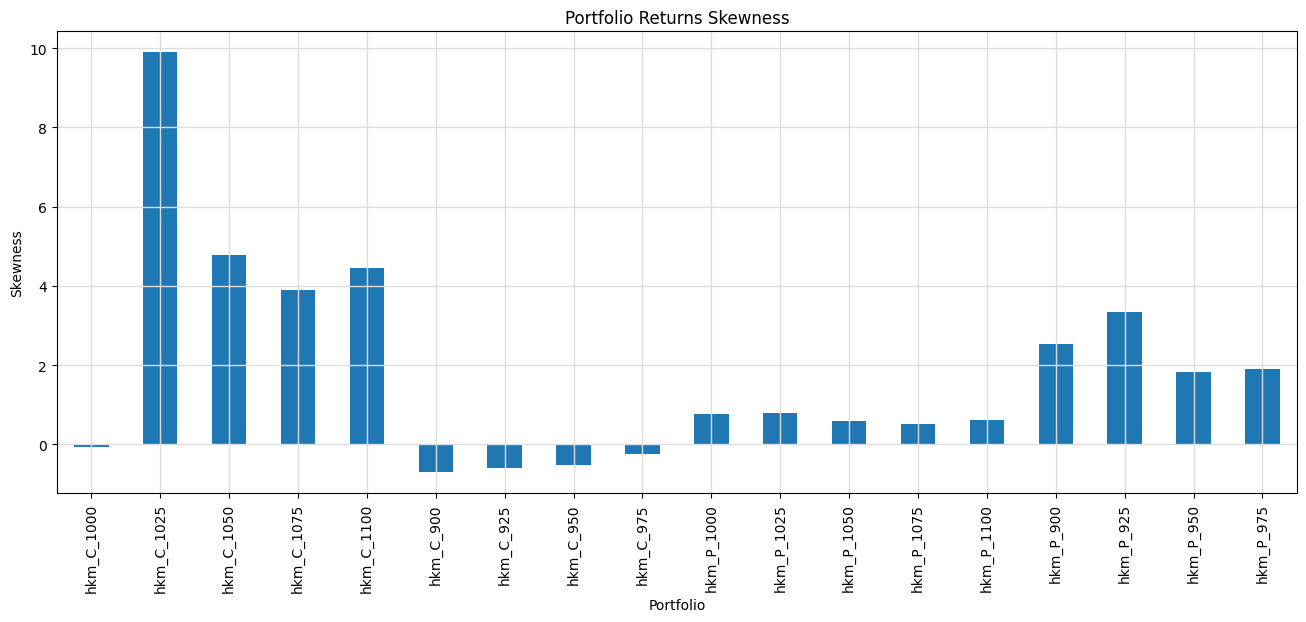

In [30]:
test_data.skew().plot(kind='bar').set_title('Portfolio Returns Skewness')
plt.xlabel('Portfolio')
plt.xticks(np.arange(len(test_data.columns)), test_data.columns, rotation=90)
plt.gca().grid(True, which='major', color='#dddddd', linewidth=1)
plt.gcf().set_size_inches(16, 6)
plt.ylabel('Skewness')
plt.show()

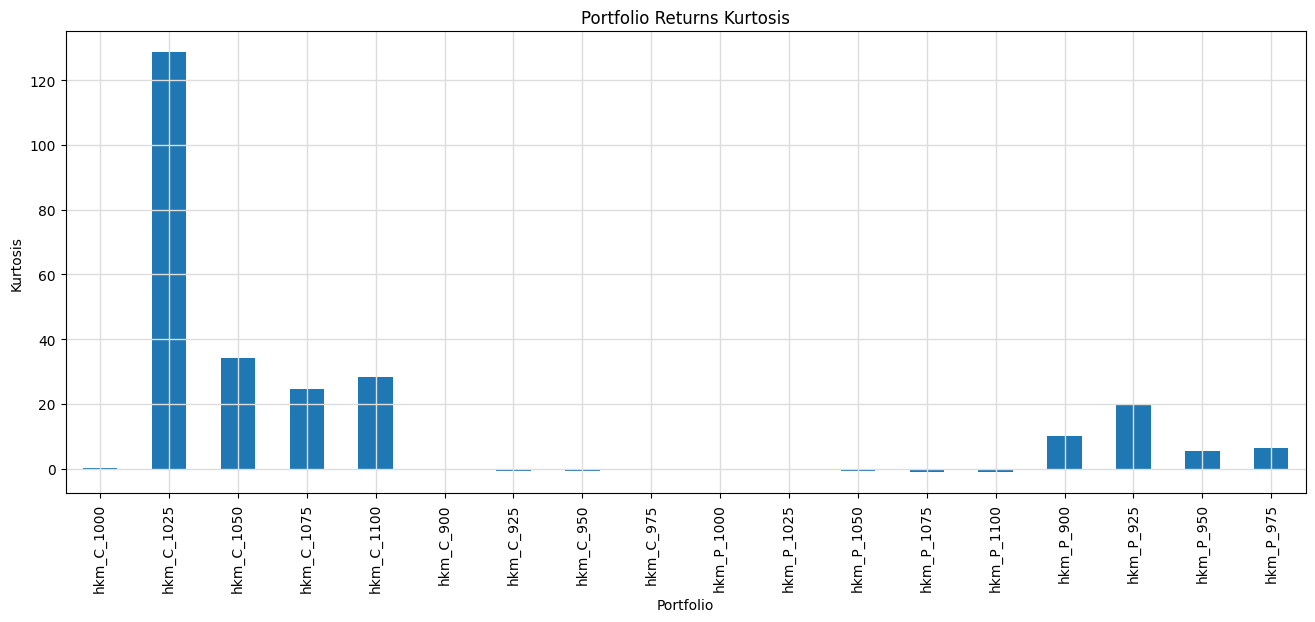

In [31]:
test_data.kurtosis().plot(kind='bar').set_title('Portfolio Returns Kurtosis')
plt.xlabel('Portfolio')
plt.xticks(np.arange(len(test_data.columns)), test_data.columns, rotation=90)
plt.gca().grid(True, which='major', color='#dddddd', linewidth=1)
plt.gcf().set_size_inches(16, 6)
plt.ylabel('Kurtosis')
# plt.yscale('log')  # Log scale for better visibility
plt.show()

#### Testing NaN-filling logic

In [32]:
test = spx_mod.set_index(['date', 'ftfsa_id'])
test.sort_index(inplace=True)
_cols = ['moneyness', 'days_to_maturity_int', 'kernel_weight','exdate']
test = test[_cols + [_ for _ in test.columns if _ not in _cols]]
test

moneyness  days_to_maturity_int  kernel_weight  \
date       ftfsa_id                                                    
1996-01-04 C_1000_30   0.987534                    16       0.412356   
           C_1000_30   0.979440                    44       0.175289   
           C_1000_30   0.987534                    44       0.412356   
           C_1025_30   1.019913                    16       1.000000   
           C_1050_30   1.028007                    16       0.282991   
...                         ...                   ...            ...   
2019-12-31 P_975_90    0.968806                    91       0.086212   
           P_975_90    0.970354                    91       0.090967   
           P_975_90    0.971902                    91       0.094524   
           P_975_90    0.973449                    91       0.096725   
           P_975_90    0.974997                    91       0.097473   

                         exdate     secid     open    close cp_flag        IV  \
date       ftfsa_id                                                             
1996-01-04 C_1000_30 1996-01-20  108105.0   621.32   617.70       C  0.082711   
           C_1000_30 1996-02-17  108105.0   621.32   617.70       C  0.090735   
           C_1000_30 1996-02-17  108105.0   621.32   617.70       C  0.092040   
           C_1025_30 1996-01-20  108105.0   621.32   617.70       C  0.097356   
           C_1050_30 1996-01-20  108105.0   621.32   617.70       C  0.101756   
...                         ...       ...      ...      ...     ...       ...   
2019-12-31 P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.154539   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.153434   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.152282   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.151165   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.150000   

                      tb_m3  volume  open_interest  best_bid  best_offer  \
date       ftfsa_id                                                        
1996-01-04 C_1000_30   5.04   444.0         5905.0   10.0000      10.375   
           C_1000_30   5.04     0.0          953.0   17.3750      18.125   
           C_1000_30   5.04     0.0          492.0   13.7500      14.500   
           C_1025_30   5.04  4022.0         5969.0    1.1875       1.375   
           C_1050_30   5.04  1627.0         6224.0    0.6250       0.750   
...                     ...     ...            ...       ...         ...   
2019-12-31 P_975_90    1.52     5.0          186.0   55.6000      56.100   
           P_975_90    1.52    11.0           77.0   56.8000      57.200   
           P_975_90    1.52     0.0          236.0   57.9000      58.400   
           P_975_90    1.52     0.0          181.0   59.1000      59.600   
           P_975_90    1.52     2.0          155.0   60.3000      60.800   

                      strike_price  contract_size  mid_price days_to_maturity  \
date       ftfsa_id                                                             
1996-01-04 C_1000_30         610.0          100.0   10.18750          16 days   
           C_1000_30         605.0          100.0   17.75000          44 days   
           C_1000_30         610.0          100.0   14.12500          44 days   
           C_1025_30         630.0          100.0    1.28125          16 days   
           C_1050_30         635.0          100.0    0.68750          16 days   
...                            ...            ...        ...              ...   
2019-12-31 P_975_90         3130.0          100.0   55.85000          91 days   
           P_975_90         3135.0          100.0   57.00000          91 days   
           P_975_90         3140.0          100.0   58.15000          91 days   
           P_975_90         3145.0          100.0   59.35000          91 days   
           P_975_90         3150.0          100.0   60.55000          

In [33]:
daily_returns

ftfsa_id,C_1000_30,C_1000_60,C_1000_90,C_1025_30,C_1025_60,C_1025_90,C_1050_30,C_1050_60,C_1050_90,C_1075_30,C_1075_60,C_1075_90,C_1100_30,C_1100_60,C_1100_90,C_900_30,C_900_60,C_900_90,C_925_30,C_925_60,C_925_90,C_950_30,C_950_60,C_950_90,C_975_30,C_975_60,C_975_90,P_1000_30,P_1000_60,P_1000_90,P_1025_30,P_1025_60,P_1025_90,P_1050_30,P_1050_60,P_1050_90,P_1075_30,P_1075_60,P_1075_90,P_1100_30,P_1100_60,P_1100_90,P_900_30,P_900_60,P_900_90,P_925_30,P_925_60,P_925_90,P_950_30,P_950_60,P_950_90,P_975_30,P_975_60,P_975_90
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-04,0.002171,NaN,NaN,0.000198,NaN,NaN,-0.003106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003604,NaN,NaN,0.006069,NaN,NaN,0.000193,NaN,NaN,0.009051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003393,NaN,NaN
1996-01-05,NaN,NaN,NaN,-0.002985,NaN,NaN,0.004674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000760,NaN,NaN,-0.007415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-09,-0.004362,-0.005736,NaN,0.011077,0.000193,NaN,0.039018,0.000195,NaN,0.008154,0.000196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000186,NaN,-0.000977,-0.005790,NaN,0.007256,0.007409,NaN,0.009330,0.000188,NaN,0.009060,0.000186,NaN,0.008965,0.000183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000191,NaN,0.011241,0.007766,NaN
1996-01-10,-0.001291,NaN,NaN,NaN,NaN,NaN,-0.003064,NaN,NaN,-0.005087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002476,NaN,NaN,NaN,NaN,NaN,0.008751,NaN,NaN,-0.015005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-22,-0.002792,NaN,NaN,-0.004186,NaN,NaN,0.004054,NaN,NaN,0.016734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009674,NaN,NaN,0.008213,NaN,NaN,0.008817,NaN,NaN,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,NaN,NaN,NaN,-0.001959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001039,-0.001018,NaN,-0.000626,0.006539,NaN,NaN,0.006020,0.003000,NaN,NaN,NaN,NaN,NaN,-0.000775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000886,0.000877,NaN,0.000702,-0.003096,NaN,NaN,0.007690,-0.007144,NaN,NaN
2019-12-26,0.000177,-0.000588,-0.001565,0.049612,0.000451,-0.001096,0.001201,0.000729,NaN,0.001499,-0.000540,-0.001867,NaN,NaN,NaN,-0.000608,-0.000771,-0.001096,-0.000200,-0.000862,-0.001450,-0.000102,-0.000799,-0.001567,0.000011,-0.000786,-0.001644,0.000736,0.001082,0.001069,0.003282,0.001151,0.001065,0.001528,0.001665,NaN,0.001659,0.004004,-0.002207,NaN,NaN,NaN,0.000699,0.000805,0.000925,0.000619,0.000816,0.001072,0.000456,0.000826,0.000696,0.002388,0.000837,0.000776
2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003203,-0.001064,-0.001036,NaN,0.000144,-0.001147,NaN,NaN,-0.001185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002822,0.000971,0.001085,NaN,0.000463,0.002847,NaN,NaN,0.002921,NaN,NaN,NaN


In [34]:
test.loc[pd.IndexSlice['1996-01-04':'1996-01-10', 'C_1000_30'],:]  

moneyness  days_to_maturity_int  kernel_weight  \
date       ftfsa_id                                                    
1996-01-04 C_1000_30   0.987534                    16       0.412356   
           C_1000_30   0.979440                    44       0.175289   
           C_1000_30   0.987534                    44       0.412356   
1996-01-09 C_1000_30   0.976290                    39       0.112423   
           C_1000_30   0.984494                    39       0.314758   
           C_1000_30   0.992698                    39       0.572820   
1996-01-10 C_1000_30   0.977476                    10       0.272701   
           C_1000_30   0.985831                    10       0.727299   

                         exdate     secid    open   close cp_flag        IV  \
date       ftfsa_id                                                           
1996-01-04 C_1000_30 1996-01-20  108105.0  621.32  617.70       C  0.082711   
           C_1000_30 1996-02-17  108105.0  621.32  617.70       C  0.090735   
           C_1000_30 1996-02-17  108105.0  621.32  617.70       C  0.092040   
1996-01-09 C_1000_30 1996-02-17  108105.0  618.46  609.45       C  0.097121   
           C_1000_30 1996-02-17  108105.0  618.46  609.45       C  0.100478   
           C_1000_30 1996-02-17  108105.0  618.46  609.45       C  0.100392   
1996-01-10 C_1000_30 1996-01-20  108105.0  609.45  598.48       C  0.136584   
           C_1000_30 1996-01-20  108105.0  609.45  598.48       C  0.148282   

                      tb_m3  volume  open_interest  best_bid  best_offer  \
date       ftfsa_id                                                        
1996-01-04 C_1000_30   5.04   444.0         5905.0    10.000      10.375   
           C_1000_30   5.04     0.0          953.0    17.375      18.125   
           C_1000_30   5.04     0.0          492.0    13.750      14.500   
1996-01-09 C_1000_30   5.01     0.0           34.0    17.250      18.000   
           C_1000_30   5.01    11.0          404.0    13.750      14.500   
           C_1000_30   5.01     3.0          953.0    10.500      11.250   
1996-01-10 C_1000_30   5.04   534.0         8096.0    14.750      15.500   
           C_1000_30   5.04   235.0         6914.0    11.000      11.750   

                      strike_price  contract_size  mid_price days_to_maturity  \
date       ftfsa_id                                                             
1996-01-04 C_1000_30         610.0          100.0    10.1875          16 days   
           C_1000_30         605.0          100.0    17.7500          44 days   
           C_1000_30         610.0          100.0    14.1250          44 days   
1996-01-09 C_1000_30         595.0          100.0    17.6250          39 days   
           C_1000_30         600.0          100.0    14.1250          39 days   
           C_1000_30         605.0          100.0    10.8750          39 days   
1996-01-10 C_1000_30         585.0          100.0    15.1250          10 days   
           C_1000_30         590.0          100.0    11.3750          10 days   

                      pc_parity_int_rate  intrinsic    log_iv  fitted_iv  \
date       ftfsa_id                                                        
1996-01-04 C_1000_30            0.015898       7.70 -2.492403  -2.377298   
           C_1000_30            0.014622      12.70 -2.399812  -2.443314   
           C_1000_30            0.014622       7.70 -2.385532  -2.394781   
1996-01-09 C_1000_30            0.014233      14.45 -2.331798  -2.388494   
           C_1000_30            0.014233       9.45 -2.297816  -2.340017   
           C_1000_30            0.014233       4.45 -2.298673  -2.297086   
1996-01-10 C_1000_30            0.020368      13.48 -1.990815  -1.917546   
           C_1000_30            0.020368       8.48 -1.908639  -1.958191   

                      rel_distance_iv moneyness_bin  stdev_iv_moneyness_bin  \
date       ftfsa_id                                                           
1996-01-04 C_1000_3

In [35]:
test.loc[pd.IndexSlice['1996-01-04':'1996-01-10', 'C_1025_30'],:]

moneyness  days_to_maturity_int  kernel_weight  \
date       ftfsa_id                                                    
1996-01-04 C_1025_30   1.019913                    16       1.000000   
1996-01-05 C_1025_30   1.021550                    15       1.000000   
1996-01-09 C_1025_30   1.000902                    11       0.023004   
           C_1025_30   1.017311                    11       0.122083   
           C_1025_30   1.000902                    39       0.093288   
           C_1025_30   1.009107                    39       0.266554   
           C_1025_30   1.017311                    39       0.495071   

                         exdate     secid    open   close cp_flag        IV  \
date       ftfsa_id                                                           
1996-01-04 C_1025_30 1996-01-20  108105.0  621.32  617.70       C  0.097356   
1996-01-05 C_1025_30 1996-01-20  108105.0  617.70  616.71       C  0.091355   
1996-01-09 C_1025_30 1996-01-20  108105.0  618.46  609.45       C  0.091177   
           C_1025_30 1996-01-20  108105.0  618.46  609.45       C  0.099723   
           C_1025_30 1996-02-17  108105.0  618.46  609.45       C  0.092492   
           C_1025_30 1996-02-17  108105.0  618.46  609.45       C  0.120972   
           C_1025_30 1996-02-17  108105.0  618.46  609.45       C  0.111577   

                      tb_m3  volume  open_interest  best_bid  best_offer  \
date       ftfsa_id                                                        
1996-01-04 C_1025_30   5.04  4022.0         5969.0    1.1875       1.375   
1996-01-05 C_1025_30   5.03  2416.0         5947.0    0.7500       0.875   
1996-01-09 C_1025_30   5.01  1304.0         6301.0    3.7500       4.000   
           C_1025_30   5.01  6518.0         5024.0    0.8750       1.000   
           C_1025_30   5.01  2337.0         2610.0    7.2500       7.750   
           C_1025_30   5.01   288.0         1363.0    7.3750       7.500   
           C_1025_30   5.01  2083.0         6320.0    4.7500       5.000   

                      strike_price  contract_size  mid_price days_to_maturity  \
date       ftfsa_id                                                             
1996-01-04 C_1025_30         630.0          100.0    1.28125          16 days   
1996-01-05 C_1025_30         630.0          100.0    0.81250          15 days   
1996-01-09 C_1025_30         610.0          100.0    3.87500          11 days   
           C_1025_30         620.0          100.0    0.93750          11 days   
           C_1025_30         610.0          100.0    7.50000          39 days   
           C_1025_30         615.0          100.0    7.43750          39 days   
           C_1025_30         620.0          100.0    4.87500          39 days   

                      pc_parity_int_rate  intrinsic    log_iv  fitted_iv  \
date       ftfsa_id                                                        
1996-01-04 C_1025_30            0.015898        0.0 -2.329381  -2.285771   
1996-01-05 C_1025_30            0.015822        0.0 -2.393002  -2.383062   
1996-01-09 C_1025_30            0.019598        0.0 -2.394953  -2.364593   
           C_1025_30            0.019598        0.0 -2.305359  -2.368567   
           C_1025_30            0.014233        0.0 -2.380633  -2.259703   
           C_1025_30            0.014233        0.0 -2.112196  -2.227867   
           C_1025_30            0.014233        0.0 -2.193040  -2.201577   

                      rel_distance_iv moneyness_bin  stdev_iv_moneyness_bin  \
date       ftfsa_id                                                           
1996-01-04 C_1025_30         1.907866  (1.0, 1.025]                5.219336   
1996-01-05 C_1025_30         0.417130  (1.0, 1.025]                5.219336   
1996-01-09 C_1025_30         1.283913  (1.0, 1.025]                5.219336   
           C_1025_30        -2.668626  (1.0, 1.025]                5.219336   
           C_1025_30         5.351598  (1.0, 1.025]                5.219336   
        